### **Ejercicio 1**  
Dado el grafo de cómputo de la imagen siguiente (imagen: ejercicio1-grafo.jpeg), donde a=1, b=2 y c=3:
Realizar el paso forward y calcular Y.  
Realizar el paso backward y calcular el backpropagation para a,b y c:  
**a.** En forma analítica (dy/dx = 0).  
**b.** Utilizando pytorch.  
**c.** Comparar los resultados de los puntos anteriores.

In [2]:
import torch

Variables iniciales.

In [3]:
a = torch.tensor(1., requires_grad=True)
b = torch.tensor(2., requires_grad=True)
c = torch.tensor(3., requires_grad=True)

Pas forward.

In [4]:
d = a + b
e = b - c
Y = d * e

In [5]:
print(f"Valor de Y: {Y.item()}")

Valor de Y: -3.0


Paso backward.

In [6]:
Y.backward()

Obtener los Gradientes.

In [7]:
grad_a = a.grad
grad_b = b.grad
grad_c = c.grad

print(f"Gradiente de Y con respecto a a: {grad_a.item()}")
print(f"Gradiente de Y con respecto a b: {grad_b.item()}")
print(f"Gradiente de Y con respecto a c: {grad_c.item()}")

Gradiente de Y con respecto a a: -1.0
Gradiente de Y con respecto a b: 2.0
Gradiente de Y con respecto a c: -3.0


Resultados analíticos.

In [8]:
analytical_grad_a = b - c
analytical_grad_b = (b - c) + (a + b)
analytical_grad_c = -(a + b)

print(f"Gradiente analítico de Y con respecto a a: {analytical_grad_a}")
print(f"Gradiente analítico de Y con respecto a b: {analytical_grad_b}")
print(f"Gradiente analítico de Y con respecto a c: {analytical_grad_c}")

Gradiente analítico de Y con respecto a a: -1.0
Gradiente analítico de Y con respecto a b: 2.0
Gradiente analítico de Y con respecto a c: -3.0


Comparación de resultados.

In [9]:
print("Comparación de resultados:")
print(f"a - PyTorch: {grad_a.item()}, \tAnalítico: {analytical_grad_a}.")
print(f"b - PyTorch: {grad_b.item()}, \tAnalítico: {analytical_grad_b}.")
print(f"c - PyTorch: {grad_c.item()}, \tAnalítico: {analytical_grad_c}.")


Comparación de resultados:
a - PyTorch: -1.0, 	Analítico: -1.0.
b - PyTorch: 2.0, 	Analítico: 2.0.
c - PyTorch: -3.0, 	Analítico: -3.0.


### **Ejercicio 2.**  
Se desea construir un sistema de recomendación de películas. Para esto se cuenta con un dataset de las puntuaciones que los usuarios han asignado a las peliculas disponibles.  

Link dataset: https://drive.google.com/file/d/1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar/view?usp=sharing  

Para verificar la factibilidad del proyecto con datos válidos, se decide utilizar solamente las 200 películas con más votos y los usuarios que han puntuado al menos 100 películas.  

**1.** Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.  

**2.** A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula.  

**3.** Elegir un usuario al azar, una película que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con el puntaje real que el usuario asignó a dicha película.  

**4.** Realizar una recomendación de película para el usuario del punto 3 utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.  

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [11]:
def load_data():
    return pd.read_csv('./ratings.csv')

ratings = load_data()

**1.** Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.  

In [12]:
def preprocess_data(ratings):
    movie_counts = ratings['movieId'].value_counts()
    top_200_movies = movie_counts.head(200).index
    filtered_ratings = ratings[ratings['movieId'].isin(top_200_movies)]

    user_counts = filtered_ratings['userId'].value_counts()
    active_users = user_counts[user_counts >= 100].index
    filtered_ratings = filtered_ratings[filtered_ratings['userId'].isin(active_users)]

    user_id_map = {id: idx for idx, id in enumerate(filtered_ratings['userId'].unique())}
    movie_id_map = {id: idx for idx, id in enumerate(filtered_ratings['movieId'].unique())}

    filtered_ratings['userId'] = filtered_ratings['userId'].map(user_id_map)
    filtered_ratings['movieId'] = filtered_ratings['movieId'].map(movie_id_map)

    return filtered_ratings, user_id_map, movie_id_map


filtered_ratings, user_id_map, movie_id_map = preprocess_data(ratings)

**2.** A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula.

In [13]:
class ComplexRecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
    
    def forward(self, user_ids, movie_ids):
        user_embedding = self.user_embedding(user_ids)
        movie_embedding = self.movie_embedding(movie_ids)
        x = torch.cat([user_embedding, movie_embedding], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [14]:
def create_model(user_id_map, movie_id_map):
    num_users = len(user_id_map)
    num_movies = len(movie_id_map)
    embedding_size = 50
    model = ComplexRecommenderNet(num_users, num_movies, embedding_size)
    return model

model = create_model(user_id_map, movie_id_map)

Crear el conjunto de datos y el cargador de datos.

In [15]:
def create_data_loader(filtered_ratings):
    train_data, test_data = train_test_split(filtered_ratings, test_size=0.2, random_state=42)
    train_dataset = TensorDataset(torch.tensor(train_data['userId'].values, dtype=torch.int64), 
                                  torch.tensor(train_data['movieId'].values, dtype=torch.int64), 
                                  torch.tensor(train_data['rating'].values, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    return train_loader, train_data, test_data

train_loader, train_data, test_data = create_data_loader(filtered_ratings)

Epoch 0, Loss: 0.005573777835471211
Epoch 1, Loss: 0.003511468293490233
Epoch 2, Loss: 0.0026889393770101445
Epoch 3, Loss: 0.00222838731241171
Epoch 4, Loss: 0.0018456523647290414
Epoch 5, Loss: 0.001557004594899438
Epoch 6, Loss: 0.0014214050455915708
Epoch 7, Loss: 0.0012726114817067152
Epoch 8, Loss: 0.0010740965107861147
Epoch 9, Loss: 0.0009372699208109191
Epoch 10, Loss: 0.0008813254944807677
Epoch 11, Loss: 0.0008198379957186127
Epoch 12, Loss: 0.0008606813304747144
Epoch 13, Loss: 0.0007919667793127397
Epoch 14, Loss: 0.0007351653163183342
Epoch 15, Loss: 0.0006322051717520312
Epoch 16, Loss: 0.0005566494267744323
Epoch 17, Loss: 0.0005350297864492017
Epoch 18, Loss: 0.00047097295949546
Epoch 19, Loss: 0.00042665803253098773
Epoch 20, Loss: 0.0004109100894614433
Epoch 21, Loss: 0.0003691515637371965
Epoch 22, Loss: 0.0003863533994364035
Epoch 23, Loss: 0.00032579540964905863
Epoch 24, Loss: 0.0003313645688144283
Epoch 25, Loss: 0.0003792038596994071
Epoch 26, Loss: 0.000316176

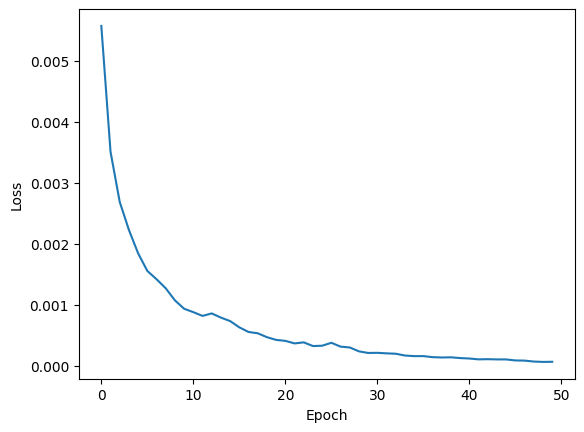

In [42]:
def train_model(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.MSELoss()
    epochs = 50
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            outputs = model(user_ids, movie_ids).squeeze()
            loss = loss_fn(outputs, ratings)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(epoch_loss)
        print(f'Epoch {epoch}, Loss: {epoch_loss}')
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
          
train_model(model, train_loader)

**3.** Elegir un usuario al azar, una película que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con el puntaje real que el usuario asignó a dicha película.

In [51]:
def test_model(model, train_data, num_users):
    random_user = torch.randint(0, num_users, (1,)).item()
    user_ratings = train_data[train_data['userId'] == random_user]
    random_movie = user_ratings.sample(1)['movieId'].values[0]
    model.eval()
    with torch.no_grad():
        predicted_rating = model(torch.tensor([random_user]), torch.tensor([random_movie])).item()
    actual_rating = user_ratings[user_ratings['movieId'] == random_movie]['rating'].values[0]
    print(f'Actual rating: {actual_rating}, Predicted rating: {predicted_rating}')
    return random_user, user_ratings

random_user, user_ratings = test_model(model, train_data, len(user_id_map))

Actual rating: 4.0, Predicted rating: 4.059525966644287


**4.** Realizar una recomendación de película para el usuario del punto 3 utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

In [52]:
def recommend_movie(model, random_user, user_ratings):
    user_embedding = model.user_embedding(torch.tensor([random_user]))
    movie_scores = torch.mm(user_embedding, model.movie_embedding.weight.t()).squeeze()
    rated_movies = user_ratings['movieId'].values
    movie_scores[rated_movies] = -np.inf
    recommended_movie = movie_scores.argmax().item()
    with torch.no_grad():
        predicted_rating = model(torch.tensor([random_user]), torch.tensor([recommended_movie])).item()
    print(f'Recommended movie: {recommended_movie}, Predicted rating: {predicted_rating}')

recommend_movie(model, random_user, user_ratings)

Recommended movie: 175, Predicted rating: 3.462156295776367
